In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import numpy as np
import datetime
from sklearn.model_selection import train_test_split
import string
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import chi2,SelectKBest
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

In [2]:
#Read file into CSV format
data = pd.read_csv('train.csv',index_col='id')

In [6]:
#Inspecting the dataset
print(data.info())
print(data.shape)
print(data.isna().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74111 entries, 6901257 to 3534845
Data columns (total 28 columns):
log_price                 74111 non-null float64
property_type             74111 non-null object
room_type                 74111 non-null object
amenities                 74111 non-null object
accommodates              74111 non-null int64
bathrooms                 73911 non-null float64
bed_type                  74111 non-null object
cancellation_policy       74111 non-null object
cleaning_fee              74111 non-null bool
city                      74111 non-null object
description               74111 non-null object
first_review              58247 non-null object
host_has_profile_pic      73923 non-null object
host_identity_verified    73923 non-null object
host_response_rate        55812 non-null object
host_since                73923 non-null object
instant_bookable          74111 non-null object
last_review               58284 non-null object
latitude            

# Functions

In [3]:
#Function to impute the mean of a column for its missing values
def impute_mean(dataframe,column_list):
    for col in column_list:
        dataframe[col].fillna(dataframe[col].mean(),inplace = True)

#Function to visualize missing values in a dataframe
def view_missing_values(dataframe):
    import matplotlib.pyplot as plt
    num = dataframe.isna().sum()
    perc = dataframe.isna().sum()/(len(data.index))
    perc_plot = perc[perc>0]*100
    num_plot = num[num>0]
    if num_plot.sum() == 0:
        print('Looks like there are no missing values')
    else:
        plt.rcParams.update({'font.size':21})
        fig, ax = plt.subplots(1,2,figsize = (50,30))
        ax[0].barh(perc_plot.index,perc_plot)
        ax[0].set_xlabel('Percentage missing(%)')
        ax[1].barh(num_plot.index,num_plot)
        ax[1].set_xlabel('No of values missing(%)')
        plt.show()
    
        
#Function calculated missing values as a percentage of total observations and drops those above a certain threshold
def drop_missing_values(dataframe,threshold):
    num = dataframe.isna().sum()
    print(num.index[num>threshold])
    to_drop = num.index[num>threshold]
    dataframe.drop(to_drop,axis = 1,inplace = True)

#Function to create box plots of dependent varibale against specific categorical features
def create_box_plot(dataframe,col_list,y):
    import matplotlib.pyplot as plt
    box_list = []
    plt.rcParams.update({'font.size':10})
    for col in col_list:
        box_list.append(dataframe.boxplot(y,col,figsize=(20,10)))
    
    return box_list


#Function to create scatter plots of dependent varibale against specific numerical features
def create_scatter_plot(dataframe,col_list,y):
    import matplotlib.pyplot as plt
    scatter_list = []
    plt.rcParams.update({'font.size':10})
    for col in col_list:
        scatter_list.append(dataframe.plot.scatter(col,y,figsize=(20,10)))
    
    return scatter_list
    

#Function to remove punctuation from a string
def remove_punct(s):
    x=""
    for i in s:
        if i not in string.punctuation:
            x = x+i
        else:
            x = x + " "
    return x

#Function that splits a specified column and creates separate dataframe for it
def split_col(dataframe,col):
    x = dataframe[[col]]
    dataframe.drop(col,axis=1,inplace = True)
    return x

#Function performs KMeans clustering for 1 to 30 clusters and saves the results in a list
def city_cluster(CUR):
    inertias = []
    ks = range(1,30)
    for k in ks:
            model = KMeans(n_clusters=k)
            model.fit(CUR)
            inertias.append(model.inertia_)
    return inertias

#Function that creates clusters based on different stratifications of a specified feature (city can be replaced with any other feature)
def city_wise_k_means(dataframe):
    inertia = {}
    cities = dataframe['city'].unique()
    for city in cities:
        CUR = data[data['city']==city][['latitude','longitude']]
        inertia[city] = city_cluster(CUR)   
    return inertia

#Function performs standard scling over a specified list of features in the dataset 
def standard_scaler(dataframe,col_list):
    from sklearn.preprocessing import StandardScaler
    to_be_scaled = dataframe[col_list]
    dataframe.drop(col_list,axis=1,inplace=True)
    scaler = StandardScaler()
    scaled_subset = scaler.fit_transform(to_be_scaled)
    scaled_dataframe = pd.DataFrame(scaled_subset,columns=to_be_scaled.columns,index=to_be_scaled.index)
    return pd.concat([dataframe,scaled_dataframe],axis=1)
    
def combine_text_features(dataframe,col_list):
    dataframe['all_text'] = ""
    for col in col_list:
        dataframe['all_text'] = dataframe['all_text'] + " " + dataframe[col]
        
    dataframe.drop(col_list,inplace=True,axis = 1)
    dataframe['all_text'] = dataframe['all_text'].apply(remove_punct)
        

# Dealing with Missing Values

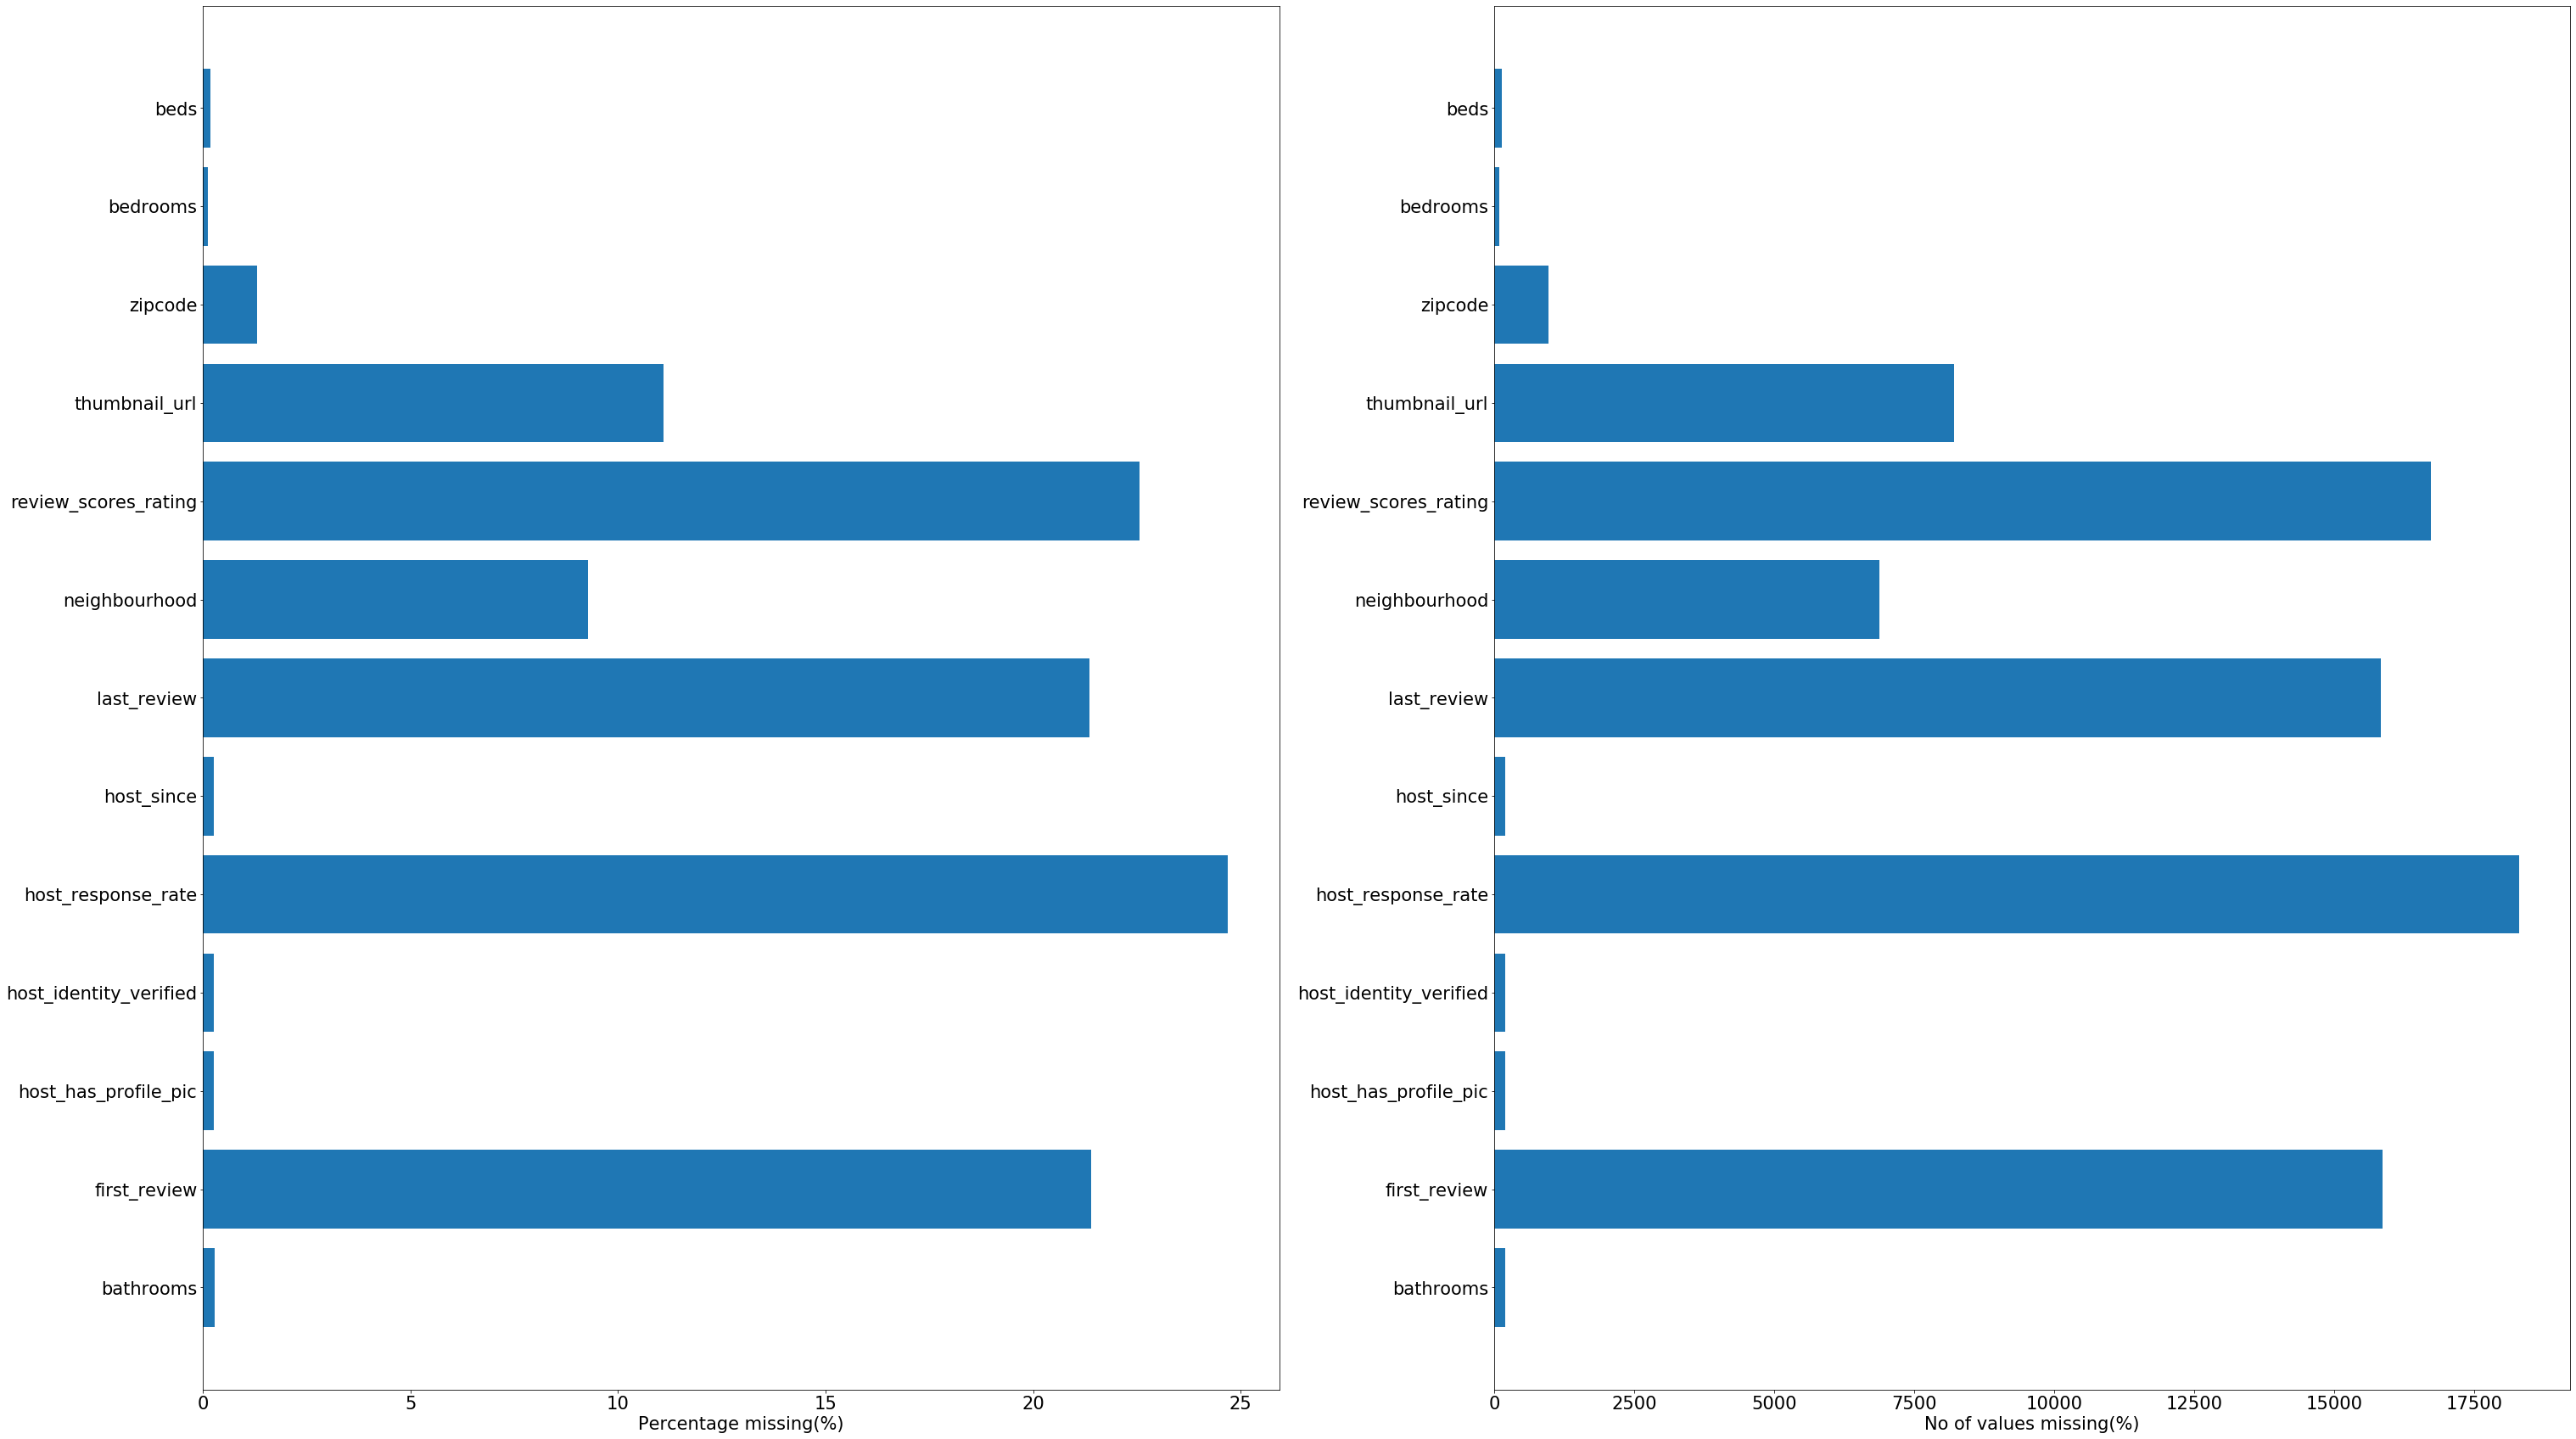

In [4]:
#Getting a sense of the missing values in the dataset
view_missing_values(data)

In [5]:
#Dropping columns that have over 200 missing values
drop_missing_values(data,200)

#Deleting observations where the host profile pic and host verification is NaN
list_delete = data[data.host_has_profile_pic.isna()].index
data.drop(list_delete,inplace=True)

#Imputed data for columns: bathrooms, bedrooms and beds by replacing Nan values with the mean
impute_mean(data,['bathrooms','bedrooms','beds'])

Index(['first_review', 'host_response_rate', 'last_review', 'neighbourhood',
       'review_scores_rating', 'thumbnail_url', 'zipcode'],
      dtype='object')


# The host_since date column

In [6]:
#Convering to datetime format
data['host_since'] = pd.to_datetime(data['host_since'])
days = []


#Calculating number of days since the present date
for item in data['host_since']:
    days.append((datetime.date.today() - item.date()).days)

days_pd = pd.DataFrame(days,index=data.index,columns = ['days_since_host'])
data = pd.concat([data,days_pd],axis=1)



#Dropping host_since feature from the dataset
data.drop('host_since',axis=1,inplace=True)

 # Categorical Variables

In [7]:
#Looking at Value Counts of text data to determine treatment: NLP or Categorical variables
categories = ['room_type','cancellation_policy','cleaning_fee','city','host_has_profile_pic', 'host_identity_verified',
       'instant_bookable']

for item in categories:
    print(data[item].value_counts())

Entire home/apt    41223
Private room       30539
Shared room         2161
Name: room_type, dtype: int64
strict             32296
flexible           22484
moderate           19014
super_strict_30      112
super_strict_60       17
Name: cancellation_policy, dtype: int64
True     54264
False    19659
Name: cleaning_fee, dtype: int64
NYC        32173
LA         22444
SF          6432
DC          5687
Chicago     3719
Boston      3468
Name: city, dtype: int64
t    73697
f      226
Name: host_has_profile_pic, dtype: int64
t    49748
f    24175
Name: host_identity_verified, dtype: int64
f    54515
t    19408
Name: instant_bookable, dtype: int64


In [8]:
#Looking at the value counts , it is clear that the bed-type is not a significant predictor since 
#71000 observations have the same bed-type. Therefore dropping the column
data.drop('bed_type',axis=1,inplace=True)


#Declaring lists of categorical variables
binary = ['cleaning_fee','host_has_profile_pic', 'host_identity_verified',
       'instant_bookable']
one_hot = ['room_type','cancellation_policy','city','lat_long_cluster']


#Simple Encoding of binary features to 1 and 0
cat_code = {'t':1,'f':0,True:1,False:0}
data.loc[:,binary] = data.loc[:,binary].replace(cat_code)

for item in binary:
    data[item] = data[item].astype('category')

# Visualizing predictiveness of features

***Categorical features

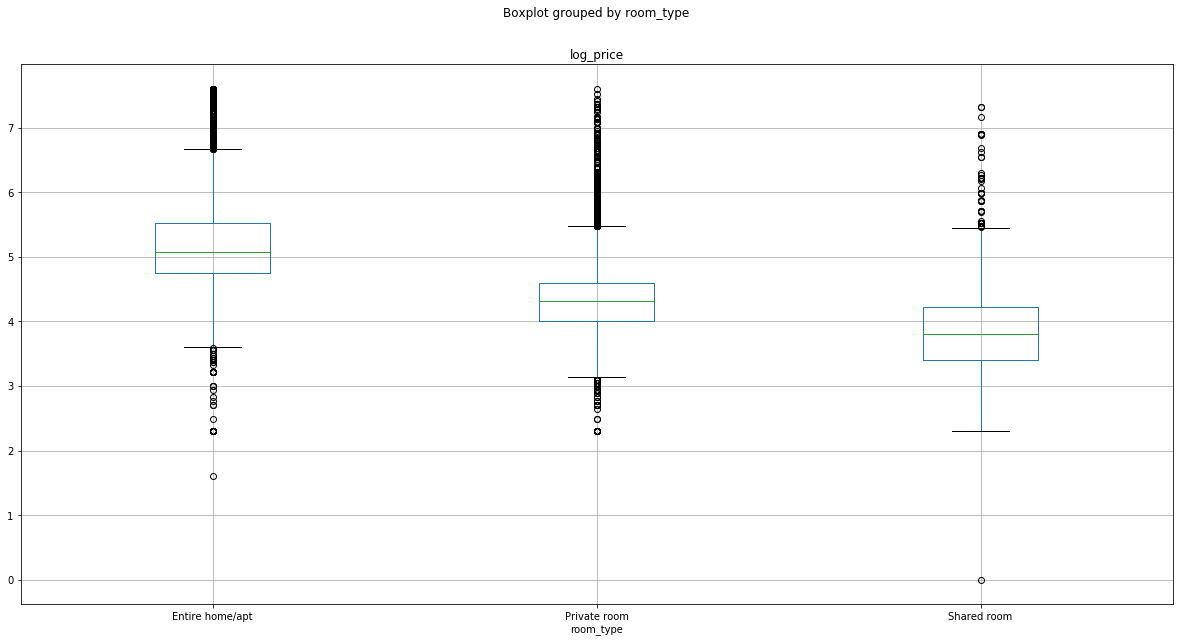

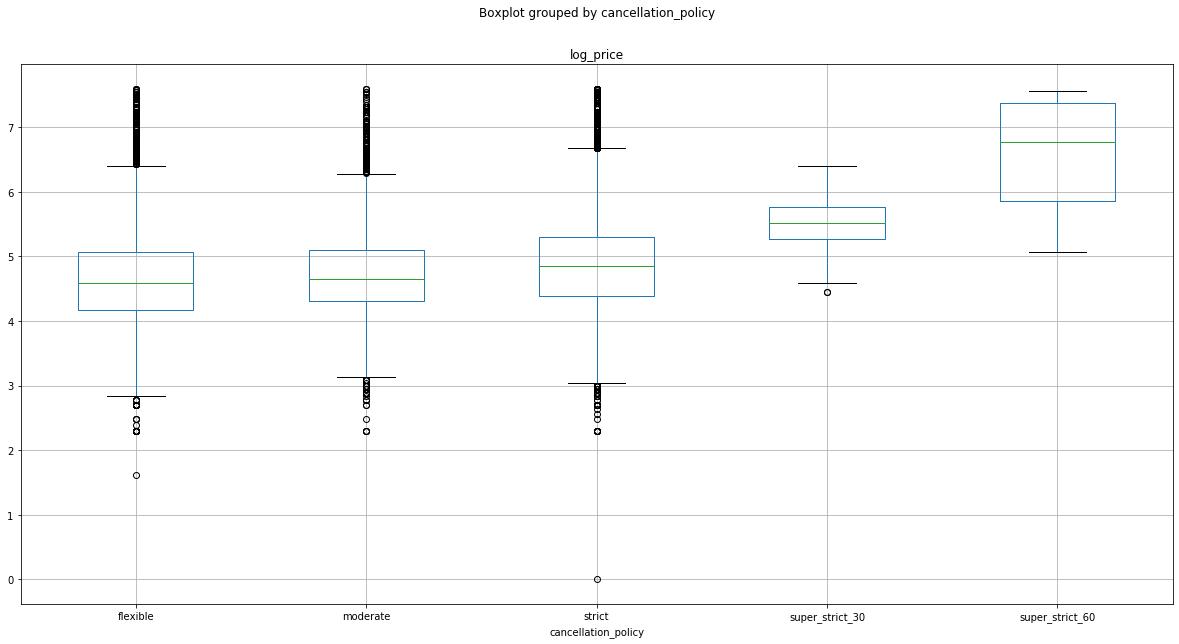

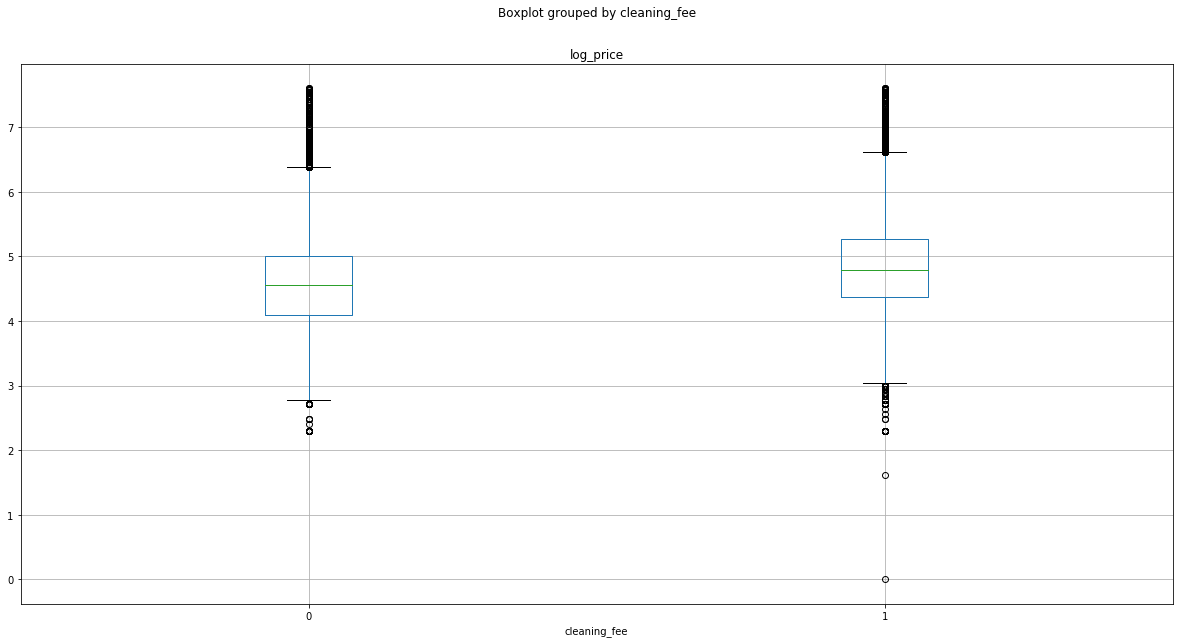

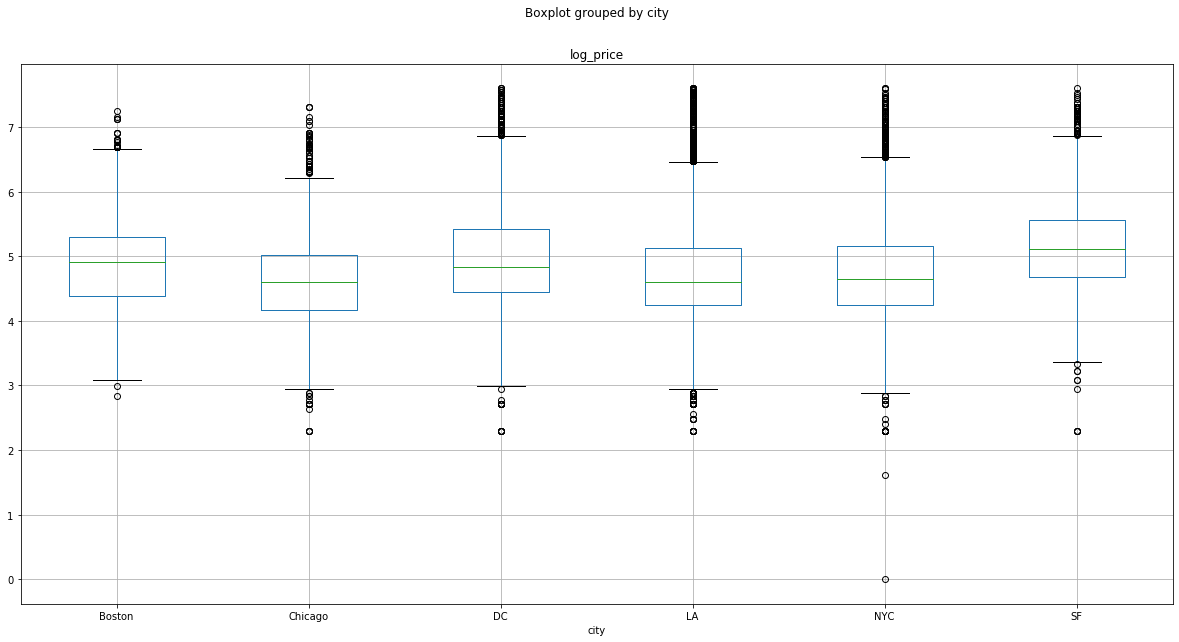

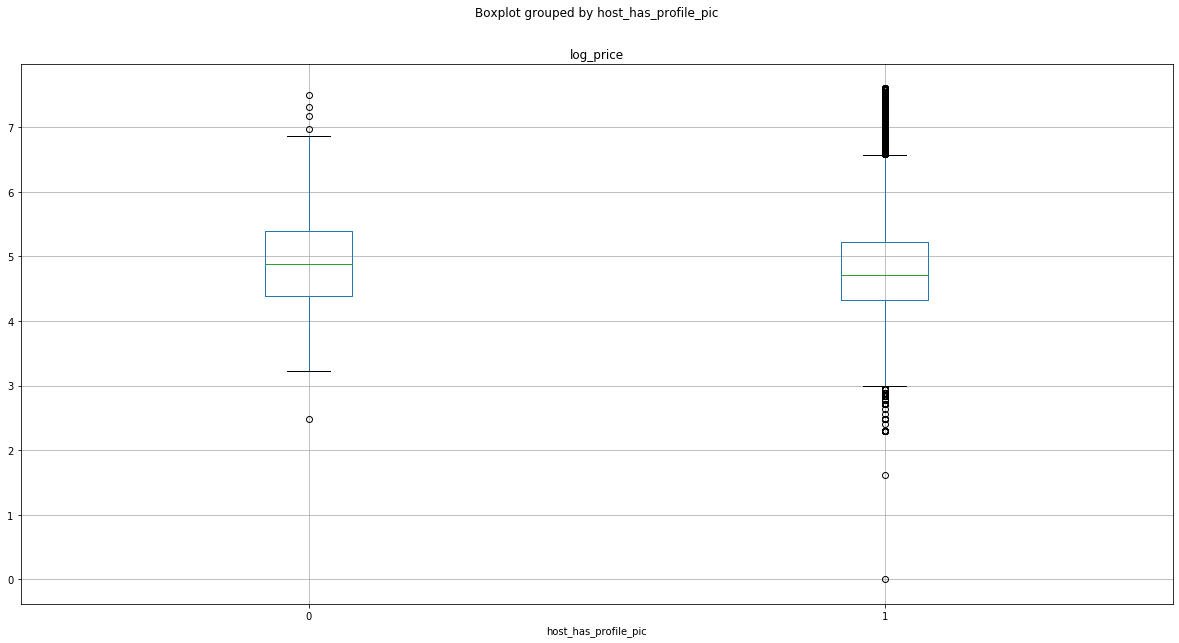

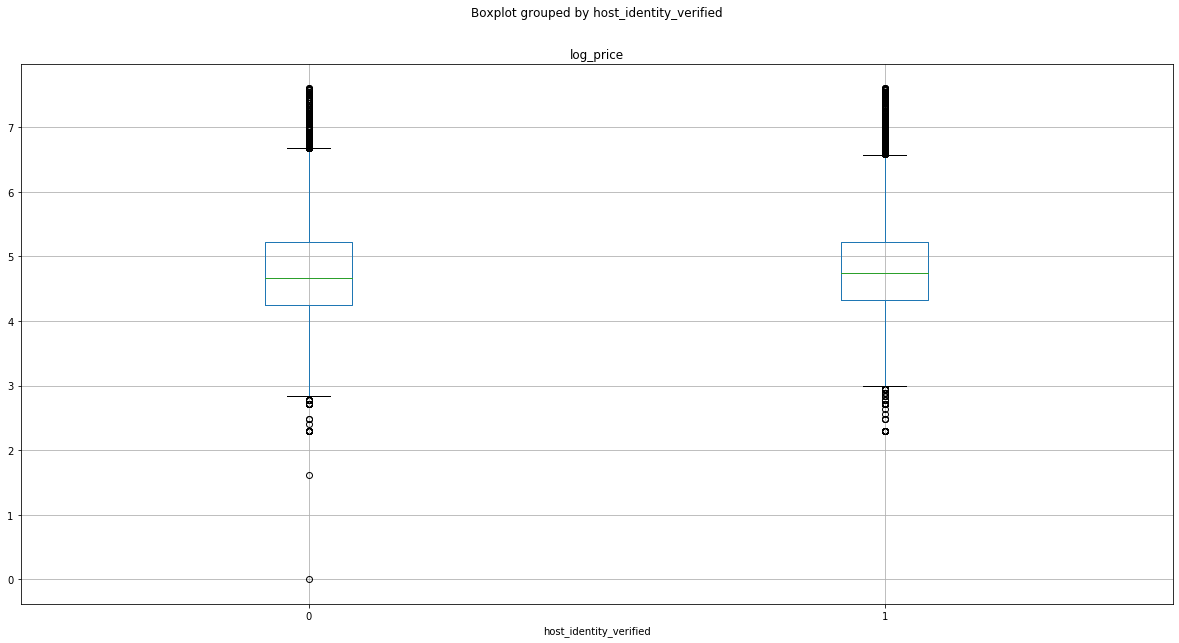

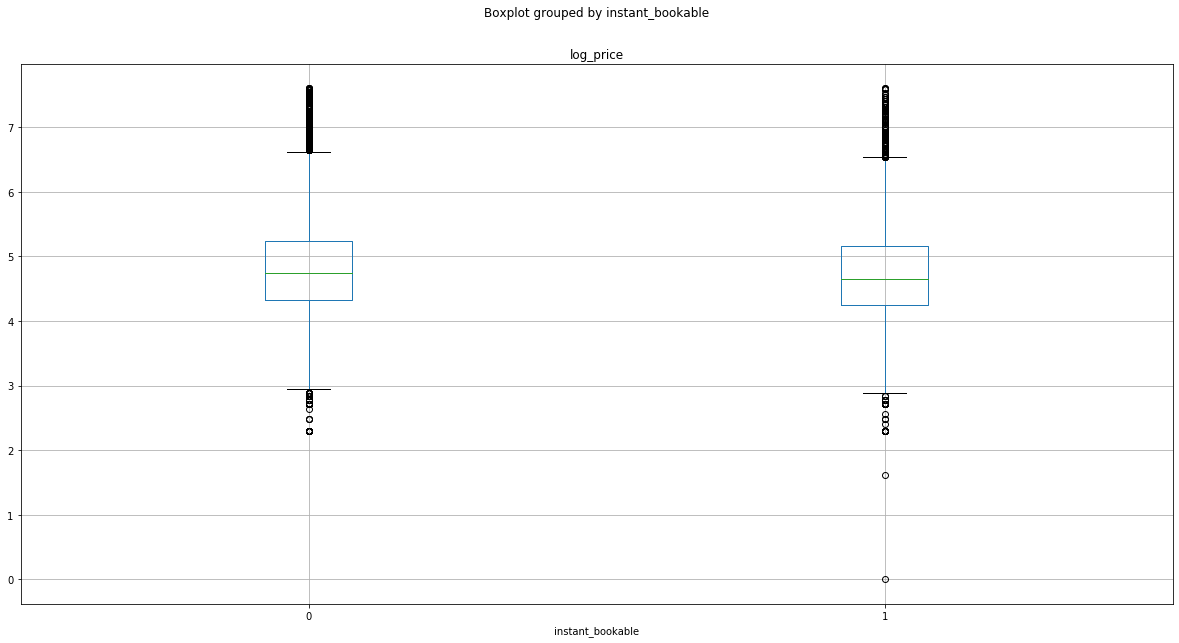

In [9]:
graphs_box = create_box_plot(data,categories,'log_price')

***Numerical features

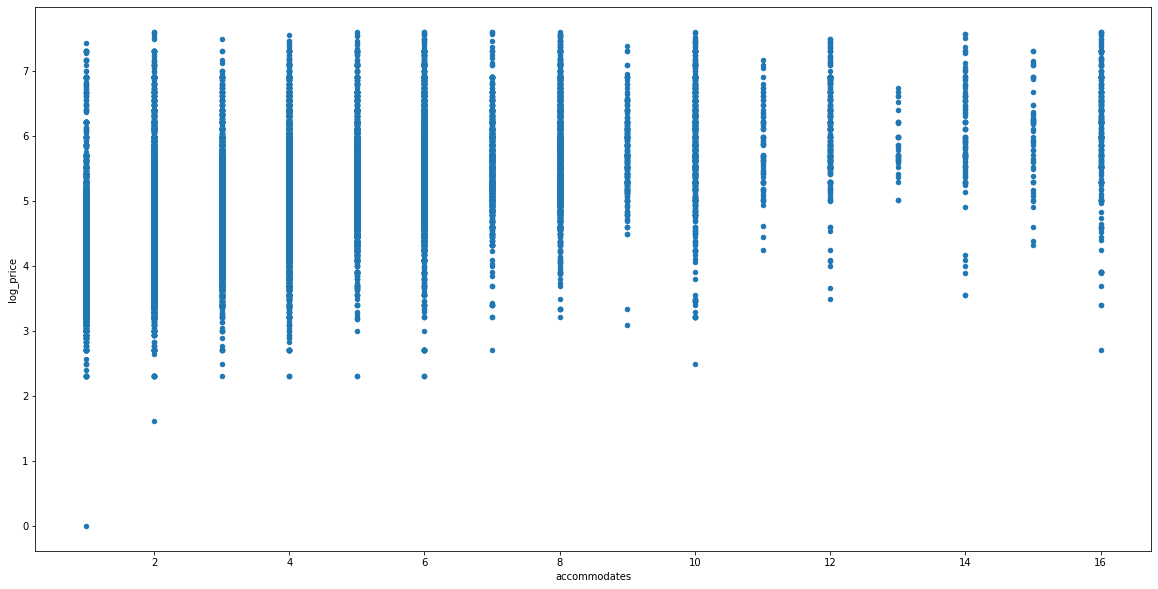

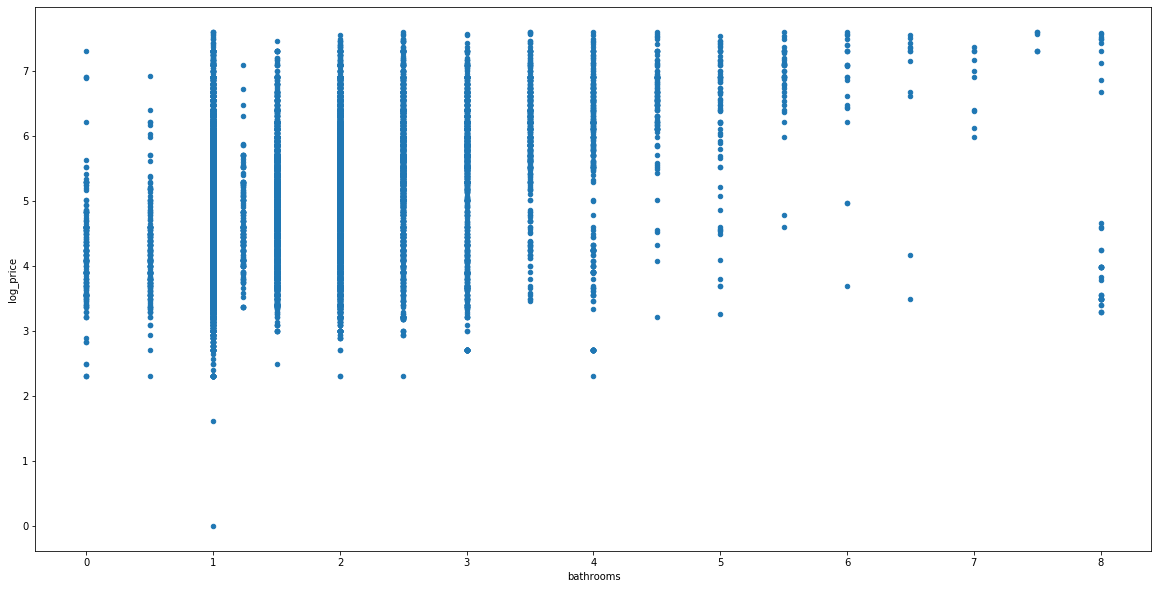

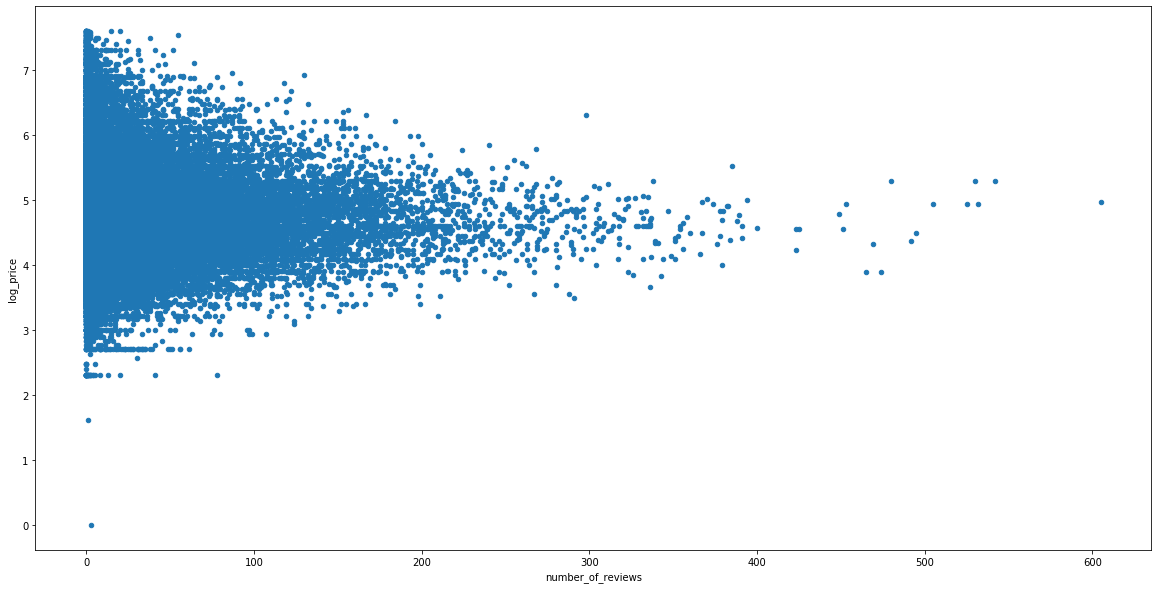

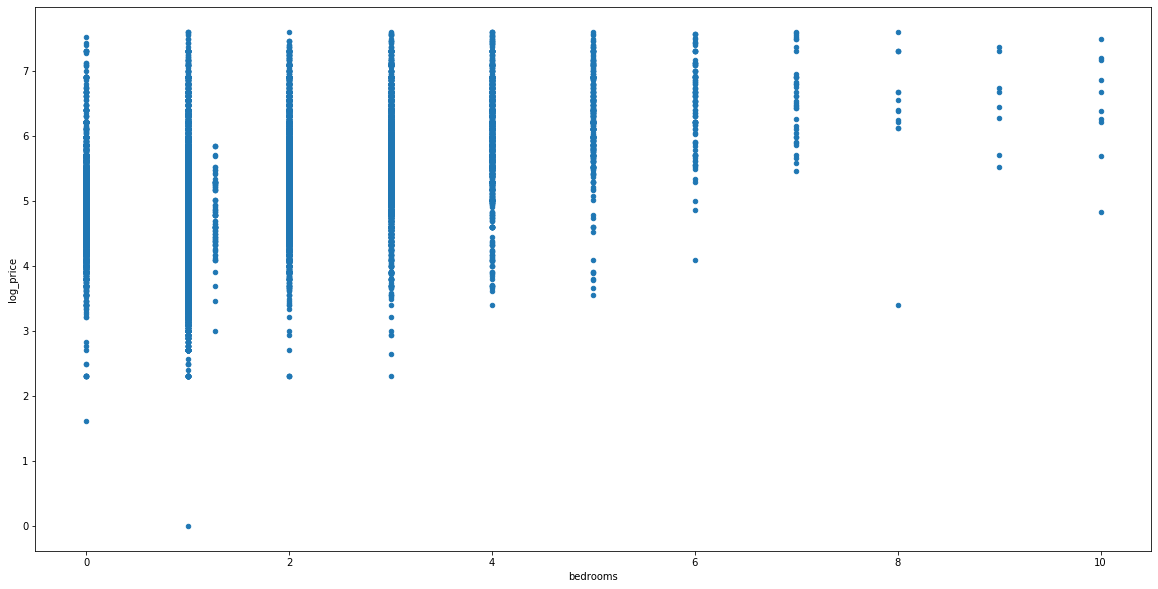

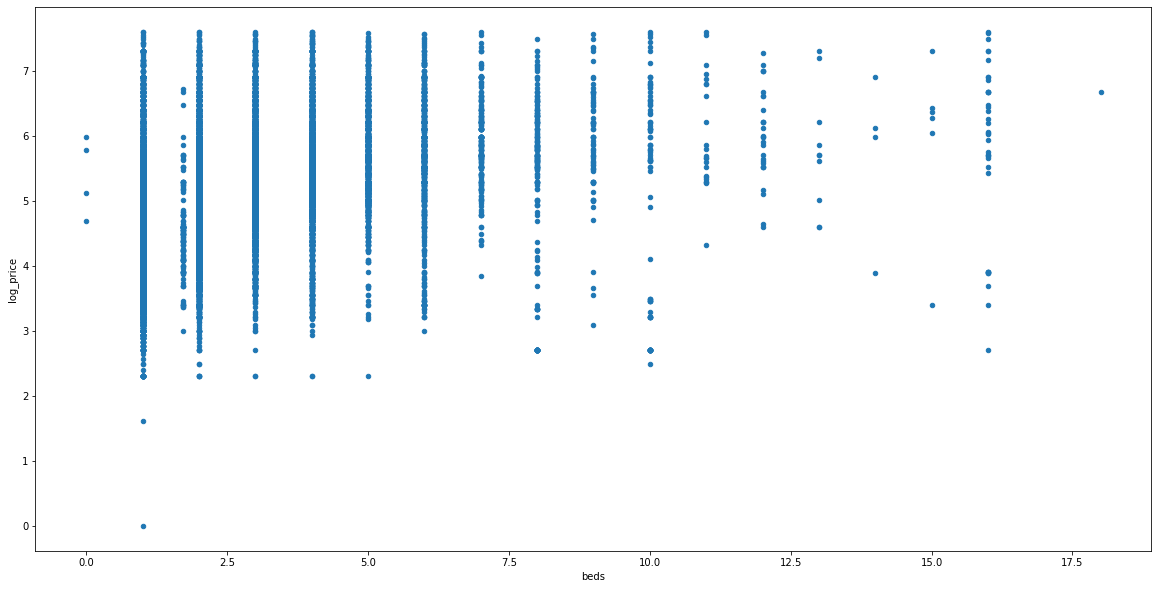

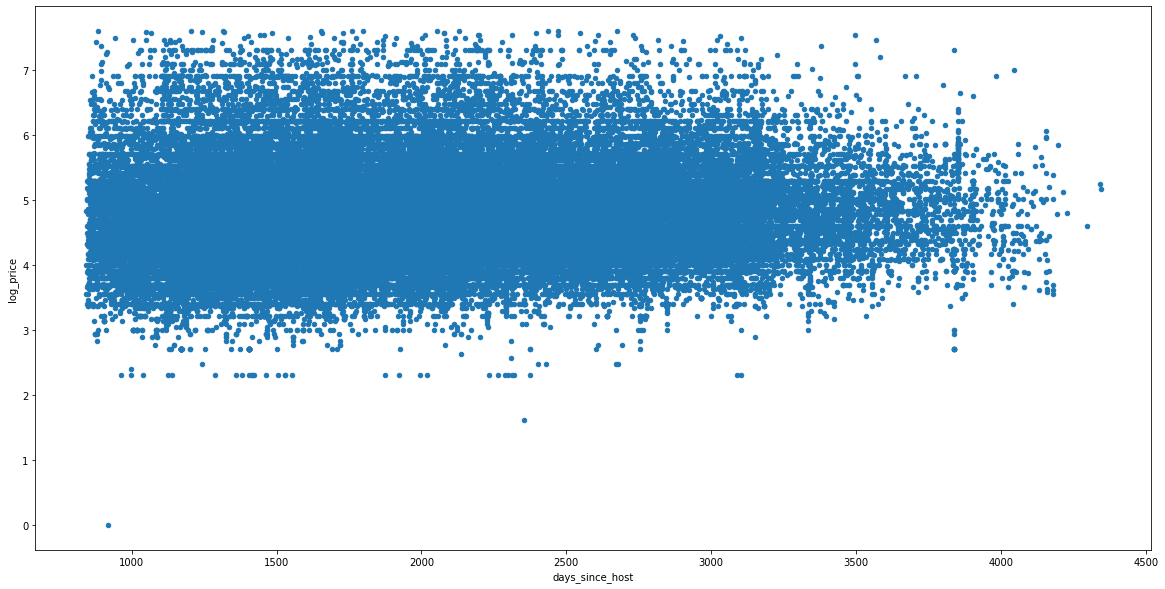

In [10]:
numerical_cols = ['accommodates','bathrooms','number_of_reviews','bedrooms','beds','days_since_host']
graphs_scatter = create_scatter_plot(data,numerical_cols,'log_price')

***Scaling the numerical features using Standard Scaler

In [11]:
data = standard_scaler(data,numerical_cols)

# Clustering

In [13]:
#Computing city-wise clusters
inertia_dict = city_wise_k_means(data)

#Hyper=parameter selection (k) for K-means clustering
ks = range(1,30)
cities = data['city'].unique()
fig,ax = plt.subplots(4,sharex=True,sharey=False,figsize = (20,20))
for i in range(0,4):
    ax[i].plot(ks,inertia_dict[cities[i]],'-o')
    ax[i].title.set_text(cities[i])

plt.figure(figsize=(50,50))
plt.show()

KeyboardInterrupt: 

***Choosing the following clusters based on the graphs above: NYC(8),LA(8),SF(4),Boston(4),DC(4),Chicago(4)

In [12]:
#zipping cities and k-values into a dictionary
cities = data['city'].unique()
cities = list(cities)
k = [8,4,4,8,4,4]
clusters = dict(zip(cities,k))


#Fitting the clustering model on each city
labels = {}
for key in clusters:
    model = KMeans(n_clusters=clusters[key])
    CUR = data[data['city']==key][['latitude','longitude']]
    model.fit(CUR)
    labels[key] = pd.DataFrame(model.predict(CUR),index=CUR.index,columns=['lat_long_cluster'])
    

    
#Tagging each city cluster label with the name of the city    
for key in labels:
        for i in range(len(labels[key].loc[:,'lat_long_cluster'])):
            labels[key].iloc[i,0] = str(labels[key].iloc[i,0]) + "_" + key
            

#Using the dictionary 'labels' to create a single dataframe that can then be merged with the main dataframe
cluster_labels = pd.DataFrame(columns=['lat_long_cluster'])
for key in labels:
    cluster_labels = pd.concat([cluster_labels,labels[key]],axis=0)
    
data = pd.concat([data,cluster_labels],axis=1)

#Dropping the latitude and longitude features
data.drop(['latitude','longitude'],inplace = True,axis = 1)

In [13]:
#Converting the rest of the categorical features into dummy variables
data = pd.get_dummies(data,columns=one_hot)

In [14]:
#declaring list of text features (to be combined)
text_columns = ['property_type','amenities','description','name']

In [15]:
#Combining all text features into 1 to create bag of words using CountVectorizer
combine_text_features(data,text_columns)

# Splitting into training and test sets

In [16]:
X_train,X_test,y_train,y_test = train_test_split(data.loc[:,data.columns!='log_price'],data[['log_price']],test_size = 0.3,random_state = 200)

# Models

In [17]:
#FunctionTransform used to generate pipeline compatible objects
get_numerical_data = FunctionTransformer((lambda x: x.loc[:,x.columns!='all_text']),validate=False)
get_text_data = FunctionTransformer((lambda x: x['all_text']),validate=False)

***Linear Regression

In [26]:
#Pipeline declared: Performs feature selection and preprocessing on numerical and text data. The output is fed to a Linear regression modelb
token = '[A-Za-z0-9]+(?=\\s+)'
pl=Pipeline([
    ('union',FeatureUnion(
        transformer_list=[
            ('numeric',Pipeline([
                ('select',get_numerical_data),('pca',PCA(n_components = 30 ))
            ])),
             ('text',Pipeline([
                 ('select',get_text_data),('vector',CountVectorizer(token_pattern=token,ngram_range=(1,2))),('TSVD',TruncatedSVD(n_components = 150 ))
             ]))
        ])),
    ('clf',LinearRegression())
])

In [21]:
cv_scores = cross_val_score(pl,X_train,y_train,cv=5)
np.mean(cv_scores)

***Avg cross-validated R-squared 0.64

In [29]:
pl.fit(X_train,y_train)
y_pred = pl.predict(X_test)
r2_score(y_test,y_pred)

Pipeline(memory=None,
         steps=[('union',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('numeric',
                                                 Pipeline(memory=None,
                                                          steps=[('select',
                                                                  FunctionTransformer(accept_sparse=False,
                                                                                      check_inverse=True,
                                                                                      func=<function <lambda> at 0x00000269512565E8>,
                                                                                      inv_kw_args=None,
                                                                                      inverse_func=None,
                                                                                      kw_args=None,
                                              

***R-squared on Test set 0.64

***Random Forest

In [32]:
token = '[A-Za-z0-9]+(?=\\s+)'
rf_pl=Pipeline([
    ('union',FeatureUnion(
        transformer_list=[
            ('numeric',Pipeline([
                ('select',get_numerical_data),('pca',PCA(n_components = 25 ))
            ])),
             ('text',Pipeline([
                 ('select',get_text_data),('vector',CountVectorizer(token_pattern=token,ngram_range=(1,2))),('TSVD',TruncatedSVD(n_components = 100 ))
             ]))
        ])),
    ('rf',RandomForestRegressor(n_estimators = 100))
])

In [34]:
rf_cv_scores = cross_val_score(pl,X_train,y_train,cv=5)

In [35]:
np.mean(rf_cv_scores)

0.6409810586055805

**Cross-validated R-squared 0.64